In [1]:
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt  
%matplotlib inline

In [53]:
path = "/home/kusum/Desktop/Heart_segmentation_dataset/CAMUS_public/database_nifti"
list = os.listdir(path)

(549, 389, 20)
[0. 1. 2. 3.]
(549, 389, 20)


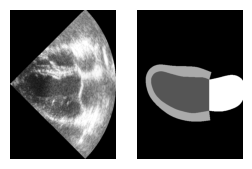

In [20]:
pth = "/home/kusum/Desktop/Heart_segmentation_dataset/CAMUS_public/database_nifti/patient0001"
img = nib.load(pth + "/patient0001_4CH_half_sequence.nii.gz")
lab = nib.load(pth + "/patient0001_4CH_half_sequence_gt.nii.gz")
lab_data = lab.get_fdata()
print(lab_data.shape)
print(np.unique(lab_data))
img_data = img.get_fdata()
print(img_data.shape)
#plot img and labels using matplotlib subplots
fig, ax = plt.subplots(1,2, figsize=(3,3))

ax[0].imshow(img_data[:,:,10], cmap="gray")
ax[1].imshow(lab_data[:,:,10], cmap="gray")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()


In [52]:
from PIL import Image
img = nib.load(pth + "/patient0001_4CH_half_sequence.nii.gz")
img = img.get_fdata()
print(img.shape)
img = np.array(img)
print(img.shape)
# img = Image.fromarray(img)

(549, 389, 20)
(549, 389, 20)


In [14]:
ax[0].imshow(img_data[:,:,10], cmap="gray")
ax[1].imshow(lab_data[:,:,10], cmap="gray")

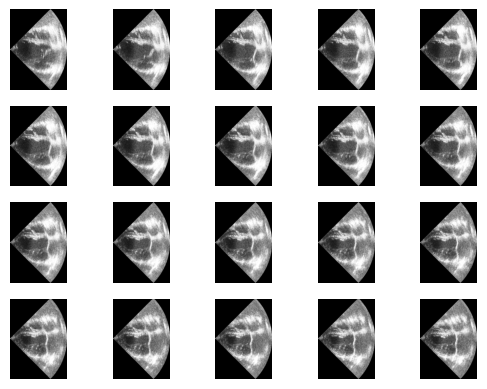

In [40]:
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(img_data[:,:,i], cmap="gray")
    # plt.title('slice %d' % i)
    plt.axis('off')
    plt.grid(False)
    plt.xticks([])


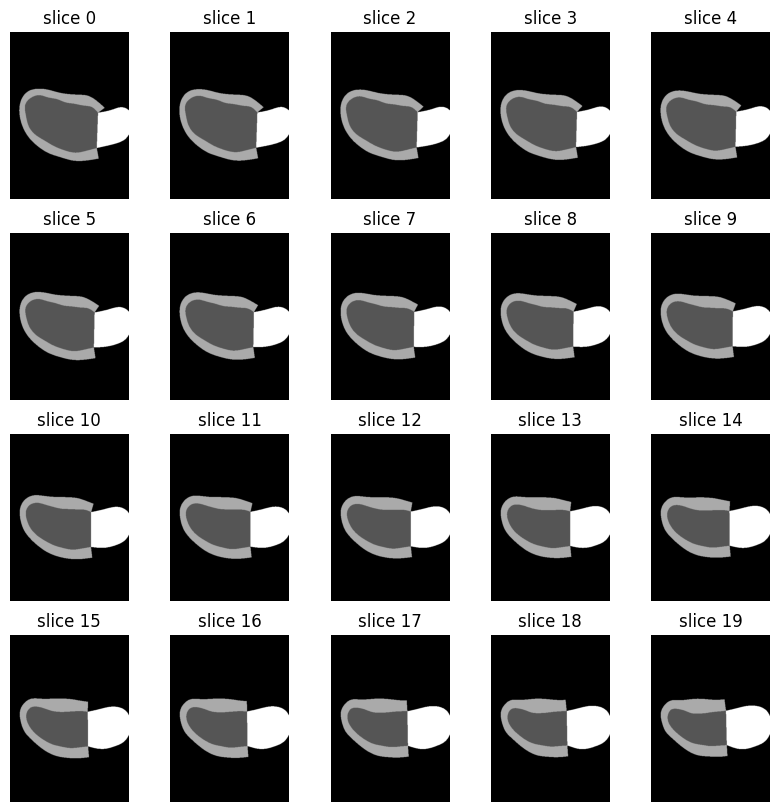

In [49]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(lab_data[:,:,i], cmap="gray")
    plt.title('slice %d' % i)
    plt.grid(False)
    plt.xticks([])
    plt.axis('off')

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable 
import time
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [66]:
class Mydataset(Dataset):
    def __init__(self, path, transformer, list):
        super(Mydataset, self).__init__()
        self.path = path
        self.transformer = transformer
        self.patient_id = list
        self.xtrain = []
        self.ytrain = []
        self.x_path = []
        self.y_path = []
        

        for patient in self.patient_id:
                us_img = os.listdir(os.path.join(self.path, patient))
                for img in us_img:
                    if "half" not in img :
                    #     count = count+1
                    #     print(count)
                    #     break
                    # else:
                        if img.endswith("gt.nii.gz"):
                            self.ytrain.append(img)
                            self.y_path.append(os.path.join(patient, img))
                        
                        elif img.endswith("nii.gz"):
                            self.xtrain.append(img)  
                            self.x_path.append(os.path.join(patient, img))  
        # print(self.xtrain)
        # print(self.ytrain)
        # print(len(us_img))
        # print(len(self.x_path))
        # print(len(self.y_path))
        # print(self.x_path[0])

    def __len__(self):
        return len(self.x_path)
    
    def __getitem__(self, idx):
         img = nib.load(os.path.join(self.path,self.x_path[idx]))
         img = img.get_fdata()
         img = np.array(img)
         img = Image.fromarray(img)
        #  img_s = img.shape()
         

         for y_name in self.y_path:
            y_split = y_name.split("_")
            x_split = self.x_path[idx].split("_")  

            if y_split[0] == x_split[0] and y_split[1] == x_split[1] and y_split[2] == x_split[2].split(".")[0]:
                # a = y_split[1]
                # b = x_split[1]
                # a_s = a.split("_")
                # b_s = b.split("_")
                # print(a_s)
                # print(b_s)
                label = nib.load(os.path.join(self.path, y_name))
                label = label.get_fdata()
                label = np.array(label)
                label = Image.fromarray(label)
                # label_s = label.shape

                # print(np.unique(label))
                
                # print("Label shape",label.shape)
                # print("Image shape",img.shape)
                # print(y_split)
                # print(x_split)
                # print(self.x_path[idx])
                # print(os.path.join(self.path, y_name))

                if self.transformer is not None:
                    img = self.transformer(img)
                    label = self.transformer(label)
                    label = label.long()
                    label = label.float()
                    label1 = torch.zeros((4,256,256))
                    label1[0,:,:] = torch.where(label[0,:,:]==0, torch.tensor(1), torch.tensor(0))
                    label1[1,:,:] = torch.where(label[0,:,:]==1, torch.tensor(1), torch.tensor(0))
                    label1[2,:,:] = torch.where(label[0,:,:]==2, torch.tensor(1), torch.tensor(0))
                    label1[3,:,:] = torch.where(label[0,:,:]==3, torch.tensor(1), torch.tensor(0))

                    return (img, label1)
                    # print("unique elements in label",np.unique(label))
            


In [67]:
transformer = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor()])
data = Mydataset(path, transformer, list)
print(len(data))

2000


In [68]:
#split the data into train and test-
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data, test_data = torch.utils.data.random_split(data, [train_size, test_size])
print(len(train_data))
print(len(test_data))

1600
400


In [69]:
train_dl =  DataLoader(data, batch_size=12, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)
print(len(train_dl))
test_dl = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=2, pin_memory=True, drop_last=False)
print(len(test_dl))

167
100


In [70]:
for batch in train_dl:
    image, lable= batch
    print(image.shape)
    print(lable.shape)
    print(lable.unique())

    break

torch.Size([12, 1, 256, 256])
torch.Size([12, 4, 256, 256])
tensor([0., 1.])


In [23]:
#import deeplabv3 model from torchvision
from torchvision import models
model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True)
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [24]:
model.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.classifier[4] = nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, 4, kernel_size=(1, 1), stride=(1, 1))
print(model)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [25]:
a = torch.randn((16,1,256,256))
out = model(a)['out']
print(out.shape)

torch.Size([16, 4, 256, 256])


In [26]:
lr = 0.001
epochs = 170
# Choosing the loss function to be Mean Square Error Loss
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
#write learning rate scheduler code for cylcic learning rate-
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [27]:
#Dice is also working fine-
def calculate_dice(pred , targets):
        smooth = 1.
        
        # inputs = F.softmax(pred, dim=1) 
        inputs = pred   
           
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice


In [28]:
def cal_iou(pred, target):
    smooth = 1e-5
    # pred = pred.argmax(dim=1).float()
    intersection = (pred * target).sum(dim=(1,2))
    union = (pred + target).sum(dim=(1,2))
    iou = (intersection + smooth) / (union - intersection + smooth)
    return iou.mean()


In [29]:
def cal_accuracy(pred, target):
    # pred = pred.argmax(dim=1)
    correct = pred.eq(target).sum()
    acc = correct.float() / pred.numel()
    return acc

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)
#check model on which device
print(next(model.parameters()).device)

cuda:0
cuda:0


Epoch: 1/170 | Training Time: 1.7895982305208842 | Training Loss: 0.5980800117204289 | Training Accuracy: 0.8980498313903809 | Training Jaccard: 0.6236300468444824 | Training Dice: 0.2679465413093567
Epoch got completed


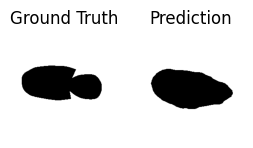

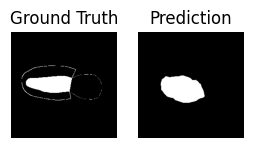

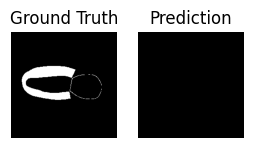

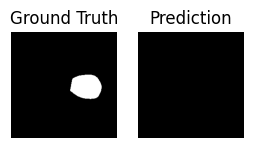

Epoch: 2/170 | Training Time: 1.765769636631012 | Training Loss: 0.3003490885753118 | Training Accuracy: 0.945642352104187 | Training Jaccard: 0.7969712018966675 | Training Dice: 0.11583305150270462
Epoch got completed
Epoch: 3/170 | Training Time: 1.7666122277577718 | Training Loss: 0.21755554674271338 | Training Accuracy: 0.9631872177124023 | Training Jaccard: 0.8636870980262756 | Training Dice: 0.07545725256204605
Epoch got completed
Epoch: 4/170 | Training Time: 1.7678206086158752 | Training Loss: 0.1808526118001538 | Training Accuracy: 0.9694387316703796 | Training Jaccard: 0.886763334274292 | Training Dice: 0.06193844601511955
Epoch got completed
Epoch: 5/170 | Training Time: 1.7779315114021301 | Training Loss: 0.16225487529160734 | Training Accuracy: 0.972321629524231 | Training Jaccard: 0.8972241282463074 | Training Dice: 0.05588249862194061
Epoch got completed
Epoch: 6/170 | Training Time: 1.7832367261250814 | Training Loss: 0.1512366481526883 | Training Accuracy: 0.9740502834

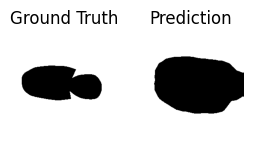

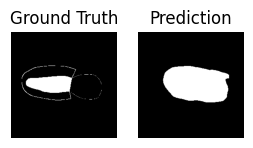

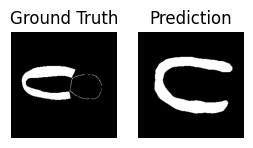

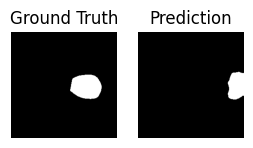

Epoch: 12/170 | Training Time: 1.7636050939559937 | Training Loss: 0.1252980284437448 | Training Accuracy: 0.9783124923706055 | Training Jaccard: 0.9185572862625122 | Training Dice: 0.043599482625722885
Epoch got completed
Epoch: 13/170 | Training Time: 1.7776438315709433 | Training Loss: 0.12285400753071209 | Training Accuracy: 0.978789210319519 | Training Jaccard: 0.920245885848999 | Training Dice: 0.04263432323932648
Epoch got completed
Epoch: 14/170 | Training Time: 1.8097474614779154 | Training Loss: 0.12049406124446206 | Training Accuracy: 0.9791913032531738 | Training Jaccard: 0.9216906428337097 | Training Dice: 0.04182189330458641
Epoch got completed
Epoch: 15/170 | Training Time: 1.8147154132525125 | Training Loss: 0.11919134221747964 | Training Accuracy: 0.9794476628303528 | Training Jaccard: 0.9225923418998718 | Training Dice: 0.041303932666778564
Epoch got completed
Epoch: 16/170 | Training Time: 1.8000190258026123 | Training Loss: 0.11701524195199955 | Training Accuracy: 0

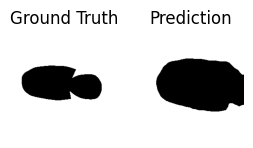

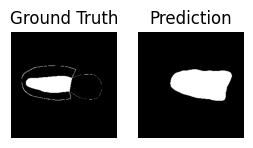

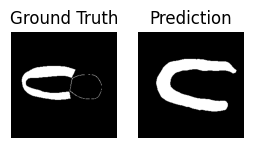

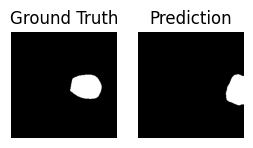

Epoch: 22/170 | Training Time: 1.784335736433665 | Training Loss: 0.11198695517050292 | Training Accuracy: 0.9807718396186829 | Training Jaccard: 0.9273213148117065 | Training Dice: 0.03862970322370529
Epoch got completed
Epoch: 23/170 | Training Time: 1.809344490369161 | Training Loss: 0.1116978658619755 | Training Accuracy: 0.9807572960853577 | Training Jaccard: 0.9272785186767578 | Training Dice: 0.038658905774354935
Epoch got completed
Epoch: 24/170 | Training Time: 1.7959823648134867 | Training Loss: 0.11077833925178665 | Training Accuracy: 0.9809481501579285 | Training Jaccard: 0.927958607673645 | Training Dice: 0.038272708654403687
Epoch got completed
Epoch: 25/170 | Training Time: 1.7747167468070983 | Training Loss: 0.10959869168118802 | Training Accuracy: 0.9812207221984863 | Training Jaccard: 0.9289422631263733 | Training Dice: 0.037724465131759644
Epoch got completed
Epoch: 26/170 | Training Time: 1.7619856437047323 | Training Loss: 0.11010415539770069 | Training Accuracy: 0

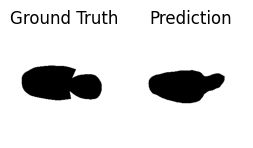

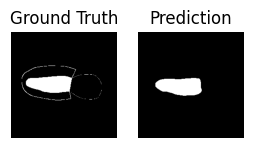

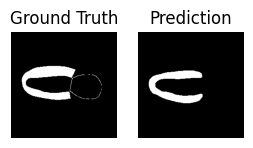

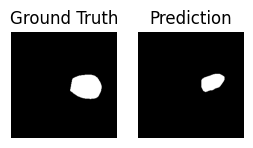

Epoch: 32/170 | Training Time: 1.864470652739207 | Training Loss: 0.10802511781632543 | Training Accuracy: 0.9814526438713074 | Training Jaccard: 0.9297658801078796 | Training Dice: 0.03725600242614746
Epoch got completed
Epoch: 33/170 | Training Time: 1.868918506304423 | Training Loss: 0.10830606591558742 | Training Accuracy: 0.9813935160636902 | Training Jaccard: 0.929567277431488 | Training Dice: 0.03737508878111839
Epoch got completed
Epoch: 34/170 | Training Time: 1.8633339285850525 | Training Loss: 0.1083948051858091 | Training Accuracy: 0.9813629984855652 | Training Jaccard: 0.9294553995132446 | Training Dice: 0.03743589296936989
Epoch got completed
Epoch: 35/170 | Training Time: 1.878822958469391 | Training Loss: 0.10791967621820416 | Training Accuracy: 0.9814581871032715 | Training Jaccard: 0.9298012852668762 | Training Dice: 0.037243861705064774
Epoch got completed
Epoch: 36/170 | Training Time: 1.8796520908673604 | Training Loss: 0.10768789454491552 | Training Accuracy: 0.98

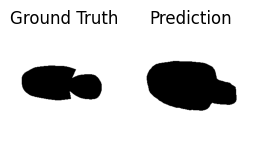

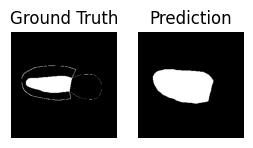

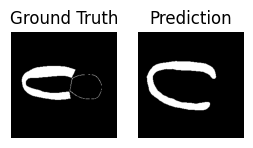

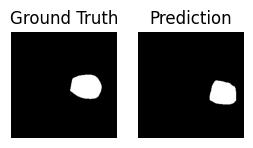

Epoch: 42/170 | Training Time: 1.8801849722862243 | Training Loss: 0.10711791745559898 | Training Accuracy: 0.9816325306892395 | Training Jaccard: 0.9304237365722656 | Training Dice: 0.03689315542578697
Epoch got completed
Epoch: 43/170 | Training Time: 1.8446595589319865 | Training Loss: 0.10712892017857044 | Training Accuracy: 0.9816452264785767 | Training Jaccard: 0.9304763078689575 | Training Dice: 0.03686794266104698
Epoch got completed
Epoch: 44/170 | Training Time: 1.8624172767003377 | Training Loss: 0.1060898614500811 | Training Accuracy: 0.981889545917511 | Training Jaccard: 0.9313647747039795 | Training Dice: 0.03637674078345299
Epoch got completed
Epoch: 45/170 | Training Time: 1.8026864767074584 | Training Loss: 0.1066826260286177 | Training Accuracy: 0.9816834330558777 | Training Jaccard: 0.9306032061576843 | Training Dice: 0.03678957372903824
Epoch got completed
Epoch: 46/170 | Training Time: 1.7640488545099895 | Training Loss: 0.10682989134938417 | Training Accuracy: 0.9

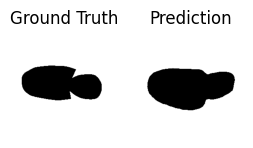

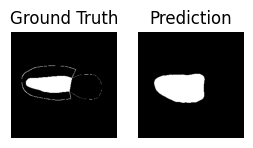

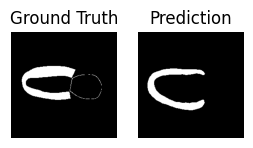

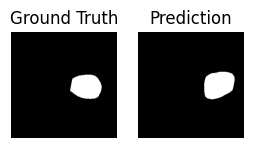

Epoch: 52/170 | Training Time: 1.7636229594548543 | Training Loss: 0.10655072072665848 | Training Accuracy: 0.9817289113998413 | Training Jaccard: 0.9307790994644165 | Training Dice: 0.0366986058652401
Epoch got completed
Epoch: 53/170 | Training Time: 1.7670154293378195 | Training Loss: 0.10642179226625466 | Training Accuracy: 0.9817442893981934 | Training Jaccard: 0.9308430552482605 | Training Dice: 0.03666828200221062
Epoch got completed
Epoch: 54/170 | Training Time: 1.803954259554545 | Training Loss: 0.10640545229533475 | Training Accuracy: 0.9817554354667664 | Training Jaccard: 0.9308646321296692 | Training Dice: 0.036646176129579544
Epoch got completed
Epoch: 55/170 | Training Time: 1.8748152693112692 | Training Loss: 0.10643737441943792 | Training Accuracy: 0.9817550778388977 | Training Jaccard: 0.930875837802887 | Training Dice: 0.036646921187639236
Epoch got completed
Epoch: 56/170 | Training Time: 1.8419806440671285 | Training Loss: 0.1060476435158781 | Training Accuracy: 0.

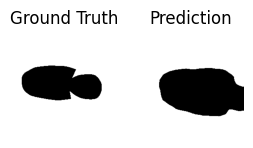

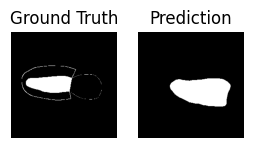

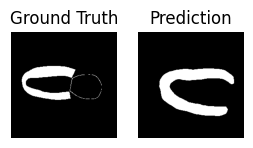

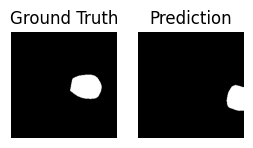

Epoch: 62/170 | Training Time: 1.7781783978144328 | Training Loss: 0.10618385351346639 | Training Accuracy: 0.9818084239959717 | Training Jaccard: 0.9310568571090698 | Training Dice: 0.03653835132718086
Epoch got completed
Epoch: 63/170 | Training Time: 1.7693940957387289 | Training Loss: 0.10588962615963941 | Training Accuracy: 0.981878936290741 | Training Jaccard: 0.9313066005706787 | Training Dice: 0.03639737889170647
Epoch got completed
Epoch: 64/170 | Training Time: 1.7901390473047891 | Training Loss: 0.10595569661455954 | Training Accuracy: 0.9818896651268005 | Training Jaccard: 0.9313633441925049 | Training Dice: 0.03637557849287987
Epoch got completed
Epoch: 65/170 | Training Time: 1.7707098285357157 | Training Loss: 0.10678541718307369 | Training Accuracy: 0.9816758632659912 | Training Jaccard: 0.9305848479270935 | Training Dice: 0.036804936826229095
Epoch got completed
Epoch: 66/170 | Training Time: 1.7569875955581664 | Training Loss: 0.10696232644562235 | Training Accuracy: 

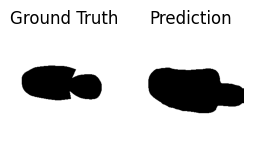

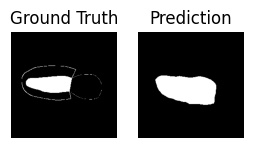

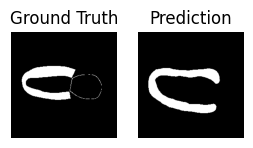

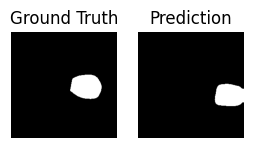

Epoch: 72/170 | Training Time: 1.7824305931727091 | Training Loss: 0.1068265741902911 | Training Accuracy: 0.98166424036026 | Training Jaccard: 0.9305464029312134 | Training Dice: 0.03682974353432655
Epoch got completed
Epoch: 73/170 | Training Time: 1.7698522845904032 | Training Loss: 0.1070371907271311 | Training Accuracy: 0.9816094040870667 | Training Jaccard: 0.930340588092804 | Training Dice: 0.03693922236561775
Epoch got completed
Epoch: 74/170 | Training Time: 1.779661194483439 | Training Loss: 0.10638999622203633 | Training Accuracy: 0.981739342212677 | Training Jaccard: 0.9308176636695862 | Training Dice: 0.03667755052447319
Epoch got completed
Epoch: 75/170 | Training Time: 1.7706209937731425 | Training Loss: 0.10580621695447111 | Training Accuracy: 0.9819062948226929 | Training Jaccard: 0.931401252746582 | Training Dice: 0.03634254261851311
Epoch got completed
Epoch: 76/170 | Training Time: 1.767638099193573 | Training Loss: 0.10598989790249727 | Training Accuracy: 0.9818602

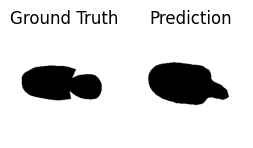

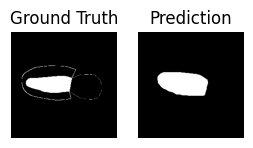

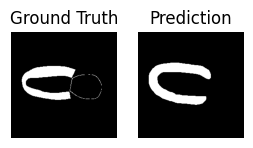

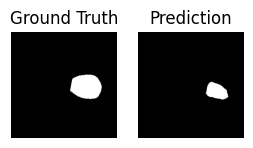

Epoch: 82/170 | Training Time: 1.7840939521789552 | Training Loss: 0.10603945693391525 | Training Accuracy: 0.9818708300590515 | Training Jaccard: 0.931289792060852 | Training Dice: 0.036412954330444336
Epoch got completed
Epoch: 83/170 | Training Time: 1.7645112991333007 | Training Loss: 0.10671969119481697 | Training Accuracy: 0.98171466588974 | Training Jaccard: 0.9307281374931335 | Training Dice: 0.03672656789422035
Epoch got completed
Epoch: 84/170 | Training Time: 1.76907426516215 | Training Loss: 0.10659333372009015 | Training Accuracy: 0.9817233681678772 | Training Jaccard: 0.9307535886764526 | Training Dice: 0.036710359156131744
Epoch got completed
Epoch: 85/170 | Training Time: 1.8047488570213317 | Training Loss: 0.10645895491460126 | Training Accuracy: 0.9817686080932617 | Training Jaccard: 0.9309234619140625 | Training Dice: 0.03661831095814705
Epoch got completed
Epoch: 86/170 | Training Time: 1.8032962560653687 | Training Loss: 0.1063920440163441 | Training Accuracy: 0.98

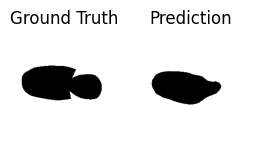

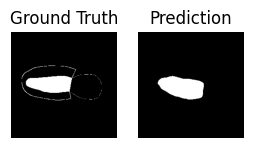

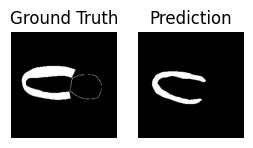

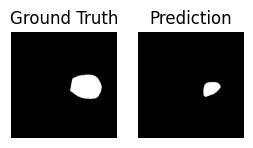

Epoch: 92/170 | Training Time: 1.77980527083079 | Training Loss: 0.10620814044318513 | Training Accuracy: 0.9817981123924255 | Training Jaccard: 0.9310249090194702 | Training Dice: 0.03655911237001419
Epoch got completed
Epoch: 93/170 | Training Time: 1.799681544303894 | Training Loss: 0.10686006227474727 | Training Accuracy: 0.9816563129425049 | Training Jaccard: 0.9305040836334229 | Training Dice: 0.03684619441628456
Epoch got completed
Epoch: 94/170 | Training Time: 1.8079283992449442 | Training Loss: 0.10643690199909096 | Training Accuracy: 0.9817570447921753 | Training Jaccard: 0.9308834671974182 | Training Dice: 0.03664286434650421
Epoch got completed
Epoch: 95/170 | Training Time: 1.7969105203946432 | Training Loss: 0.10642539638423634 | Training Accuracy: 0.9817554354667664 | Training Jaccard: 0.9308788776397705 | Training Dice: 0.03664547950029373
Epoch got completed
Epoch: 96/170 | Training Time: 1.7643490552902221 | Training Loss: 0.10753370518099048 | Training Accuracy: 0.9

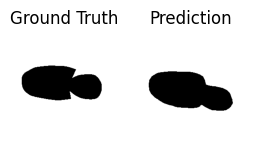

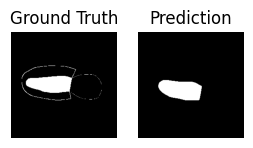

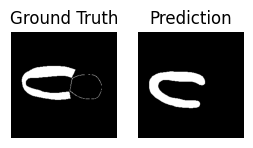

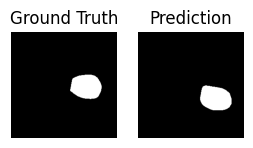

Epoch: 102/170 | Training Time: 1.7720163663228352 | Training Loss: 0.1064196479266989 | Training Accuracy: 0.9817717671394348 | Training Jaccard: 0.9309265613555908 | Training Dice: 0.03661303222179413
Epoch got completed
Epoch: 103/170 | Training Time: 1.7728599707285564 | Training Loss: 0.10594307238648752 | Training Accuracy: 0.9818668961524963 | Training Jaccard: 0.931266725063324 | Training Dice: 0.036421239376068115
Epoch got completed
Epoch: 104/170 | Training Time: 1.775401488939921 | Training Loss: 0.10728584479785964 | Training Accuracy: 0.9815436005592346 | Training Jaccard: 0.930124819278717 | Training Dice: 0.037071019411087036
Epoch got completed
Epoch: 105/170 | Training Time: 1.7645025491714477 | Training Loss: 0.1066815527880977 | Training Accuracy: 0.9817109107971191 | Training Jaccard: 0.9307177066802979 | Training Dice: 0.036733951419591904
Epoch got completed
Epoch: 106/170 | Training Time: 1.7948288599650064 | Training Loss: 0.1063613522641673 | Training Accuracy

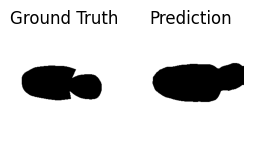

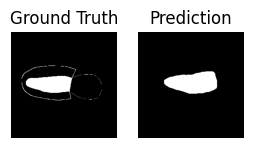

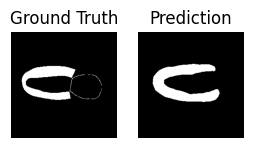

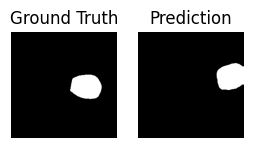

Epoch: 112/170 | Training Time: 1.8044863224029541 | Training Loss: 0.10630128447881002 | Training Accuracy: 0.981783926486969 | Training Jaccard: 0.93097323179245 | Training Dice: 0.03658699616789818
Epoch got completed
Epoch: 113/170 | Training Time: 1.8071871280670166 | Training Loss: 0.10611413584319418 | Training Accuracy: 0.9818500876426697 | Training Jaccard: 0.9312098026275635 | Training Dice: 0.03645477816462517
Epoch got completed
Epoch: 114/170 | Training Time: 1.780120567480723 | Training Loss: 0.10618888907982203 | Training Accuracy: 0.9818263053894043 | Training Jaccard: 0.9311307072639465 | Training Dice: 0.03650393337011337
Epoch got completed
Epoch: 115/170 | Training Time: 1.7854612350463868 | Training Loss: 0.1064280875607165 | Training Accuracy: 0.9817602634429932 | Training Jaccard: 0.9309155344963074 | Training Dice: 0.03663603216409683
Epoch got completed
Epoch: 116/170 | Training Time: 1.7590333382288614 | Training Loss: 0.10606222207139353 | Training Accuracy: 

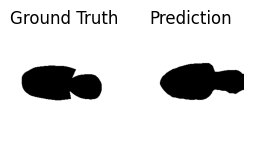

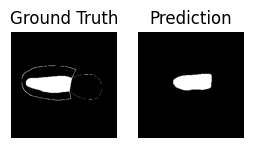

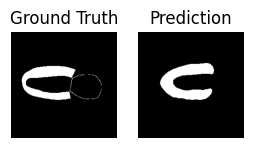

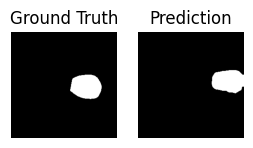

Epoch: 122/170 | Training Time: 1.779428203900655 | Training Loss: 0.10633734368278595 | Training Accuracy: 0.9817615151405334 | Training Jaccard: 0.9309006333351135 | Training Dice: 0.03663370758295059
Epoch got completed
Epoch: 123/170 | Training Time: 1.7742927153905232 | Training Loss: 0.10597438815825 | Training Accuracy: 0.9818419218063354 | Training Jaccard: 0.9311869740486145 | Training Dice: 0.03647064045071602
Epoch got completed
Epoch: 124/170 | Training Time: 1.789167853196462 | Training Loss: 0.10617453890467832 | Training Accuracy: 0.9818158149719238 | Training Jaccard: 0.9310857057571411 | Training Dice: 0.036524057388305664
Epoch got completed
Epoch: 125/170 | Training Time: 1.787480394045512 | Training Loss: 0.10651240167682043 | Training Accuracy: 0.9817638993263245 | Training Jaccard: 0.930914580821991 | Training Dice: 0.03662855178117752
Epoch got completed
Epoch: 126/170 | Training Time: 1.7813815077145894 | Training Loss: 0.10644865473230442 | Training Accuracy: 0

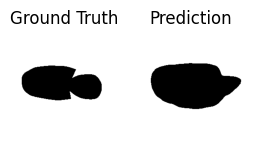

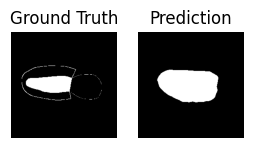

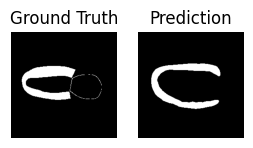

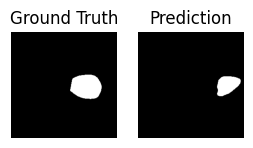

Epoch: 132/170 | Training Time: 1.7727887948354086 | Training Loss: 0.10655888495687953 | Training Accuracy: 0.9817512035369873 | Training Jaccard: 0.9308709502220154 | Training Dice: 0.036652594804763794
Epoch got completed
Epoch: 133/170 | Training Time: 1.769161077340444 | Training Loss: 0.10699239689968303 | Training Accuracy: 0.981647789478302 | Training Jaccard: 0.930489718914032 | Training Dice: 0.03686318174004555
Epoch got completed
Epoch: 134/170 | Training Time: 1.8143102963765463 | Training Loss: 0.10612345339652307 | Training Accuracy: 0.9818556308746338 | Training Jaccard: 0.931248664855957 | Training Dice: 0.036445070058107376
Epoch got completed
Epoch: 135/170 | Training Time: 1.81595667997996 | Training Loss: 0.10594389360108061 | Training Accuracy: 0.9818918108940125 | Training Jaccard: 0.9313591122627258 | Training Dice: 0.03637271746993065
Epoch got completed
Epoch: 136/170 | Training Time: 1.8112661600112916 | Training Loss: 0.10679904358115738 | Training Accuracy:

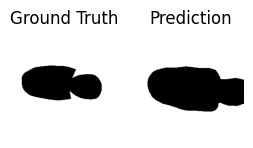

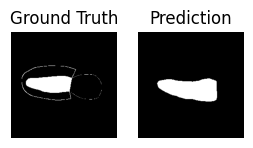

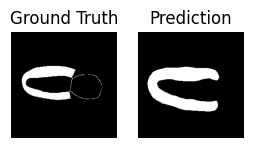

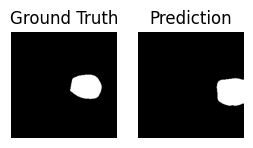

Epoch: 142/170 | Training Time: 1.821040157477061 | Training Loss: 0.10664959648947515 | Training Accuracy: 0.9816989302635193 | Training Jaccard: 0.9306625723838806 | Training Dice: 0.03675878420472145
Epoch got completed
Epoch: 143/170 | Training Time: 1.8128394484519958 | Training Loss: 0.10600011363000927 | Training Accuracy: 0.9818463325500488 | Training Jaccard: 0.9311950206756592 | Training Dice: 0.036462534219026566
Epoch got completed
Epoch: 144/170 | Training Time: 1.7641687909762065 | Training Loss: 0.1065282602599281 | Training Accuracy: 0.9817245602607727 | Training Jaccard: 0.9307535886764526 | Training Dice: 0.036707572638988495
Epoch got completed
Epoch: 145/170 | Training Time: 1.80130531390508 | Training Loss: 0.10667162165491881 | Training Accuracy: 0.9816964268684387 | Training Jaccard: 0.9306676387786865 | Training Dice: 0.03676465153694153
Epoch got completed
Epoch: 146/170 | Training Time: 1.7771459142367045 | Training Loss: 0.10678567929182224 | Training Accurac

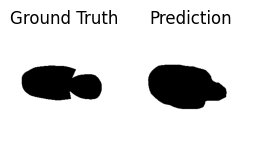

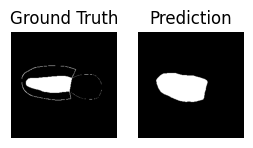

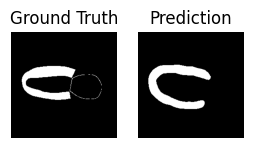

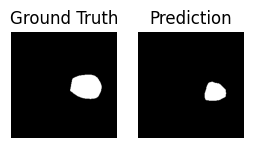

Epoch: 152/170 | Training Time: 1.7664680401484172 | Training Loss: 0.10639010244857765 | Training Accuracy: 0.9817917943000793 | Training Jaccard: 0.93100506067276 | Training Dice: 0.03657304868102074
Epoch got completed
Epoch: 153/170 | Training Time: 1.7792540391286213 | Training Loss: 0.10601507265589194 | Training Accuracy: 0.9818283319473267 | Training Jaccard: 0.9311299324035645 | Training Dice: 0.036498039960861206
Epoch got completed
Epoch: 154/170 | Training Time: 1.7932845910390218 | Training Loss: 0.10676685912523441 | Training Accuracy: 0.9816491603851318 | Training Jaccard: 0.930479884147644 | Training Dice: 0.0368594191968441
Epoch got completed
Epoch: 155/170 | Training Time: 1.787013339996338 | Training Loss: 0.10630459409809398 | Training Accuracy: 0.9817689657211304 | Training Jaccard: 0.930917501449585 | Training Dice: 0.03661833703517914
Epoch got completed
Epoch: 156/170 | Training Time: 1.7693535844484964 | Training Loss: 0.10624062087007625 | Training Accuracy: 

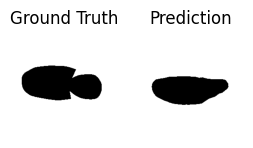

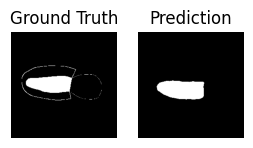

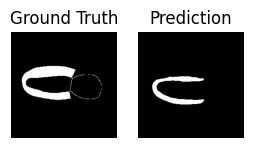

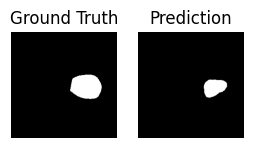

Epoch: 162/170 | Training Time: 1.8325184424718222 | Training Loss: 0.10669927539939653 | Training Accuracy: 0.9816846251487732 | Training Jaccard: 0.9306170344352722 | Training Dice: 0.036787305027246475
Epoch got completed
Epoch: 163/170 | Training Time: 1.8052915612856546 | Training Loss: 0.10571607394132786 | Training Accuracy: 0.9819158911705017 | Training Jaccard: 0.9314391613006592 | Training Dice: 0.0363214872777462
Epoch got completed
Epoch: 164/170 | Training Time: 1.807843518257141 | Training Loss: 0.10638888095488805 | Training Accuracy: 0.9817288517951965 | Training Jaccard: 0.9307688474655151 | Training Dice: 0.0366981066763401
Epoch got completed
Epoch: 165/170 | Training Time: 1.804838228225708 | Training Loss: 0.1061981385517977 | Training Accuracy: 0.9817995429039001 | Training Jaccard: 0.9310227036476135 | Training Dice: 0.036555856466293335
Epoch got completed
Epoch: 166/170 | Training Time: 1.8013620495796203 | Training Loss: 0.10638372104860351 | Training Accuracy

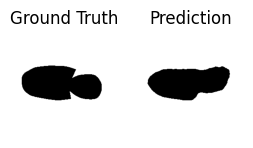

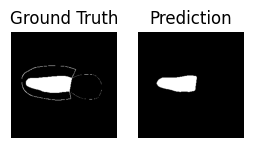

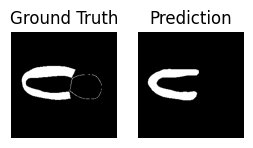

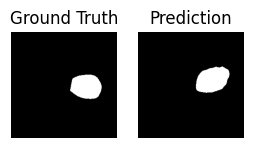

In [31]:
train_loss = []
train_acc = []
train_jacc = []
train_dice = []

model.train()
for e in range(epochs+1):
    start = time.time()

    epoch_loss = 0
    epoch_acc = 0
    epoch_iou = 0
    epoch_dice = 0

    for batch in train_dl:
        img, label = batch
        img = img.to(device).float()
        pred = model(img)['out']
        label = label.float()
        #keep pred in cpu to calculate loss
        pred = pred.cpu()

        loss = criteria(pred, label)
        pred = F.softmax(pred, dim=1)
        #put 1 if elements of pred is greater than 0.5 else 0
        pred = torch.where(pred>=0.5, torch.tensor(1), torch.tensor(0))

        acc = cal_accuracy(pred, label)
        iou = cal_iou(pred, label)
        dice = calculate_dice(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_iou += iou
        epoch_dice += dice
    scheduler.step()
    end = time.time()
    training_time = (end - start)/60
    train_loss.append(epoch_loss/len(train_dl))
    train_acc.append(epoch_acc/len(train_dl))
    train_jacc.append(epoch_iou/len(train_dl))
    train_dice.append(epoch_dice/len(train_dl))

    print("Epoch: {}/{} | Training Time: {} | Training Loss: {} | Training Accuracy: {} | Training Jaccard: {} | Training Dice: {}".format(e+1, epochs, training_time, epoch_loss/len(train_dl), epoch_acc/len(train_dl), epoch_iou/len(train_dl), epoch_dice/len(train_dl)))
    print("Epoch got completed")
    if e%5 == 0:    
        torch.save(model.state_dict(), "deeplabv3_model_{}.pth".format(e+1))
        #plot the labels and predictions-
    if e%10 == 0:
        for i in range(4):
            fig, ax = plt.subplots(1,2, figsize=(3,3))
            ax[0].imshow(lable[0,i,:,:], cmap="gray")
            ax[0].set_title("Ground Truth")
            ax[1].imshow(pred[0,i,:,:].detach().numpy(), cmap="gray")
            ax[1].set_title("Prediction")
            [axi.set_axis_off() for axi in ax.ravel()]
            plt.show()
    #     torch.save(model.state_dict(), "model_{}.pth".format(e+1))
    #     #plot the labels and predictions
    #     fig, ax = plt.subplots(1,2, figsize=(3,3))
    #     ax[0].imshow(label[0][1], cmap="gray")
    #     ax[1].imshow(pred[0][1].detach().numpy(), cmap="gray")
    #     [axi.set_axis_off() for axi in ax.ravel()]
    #     plt.show()


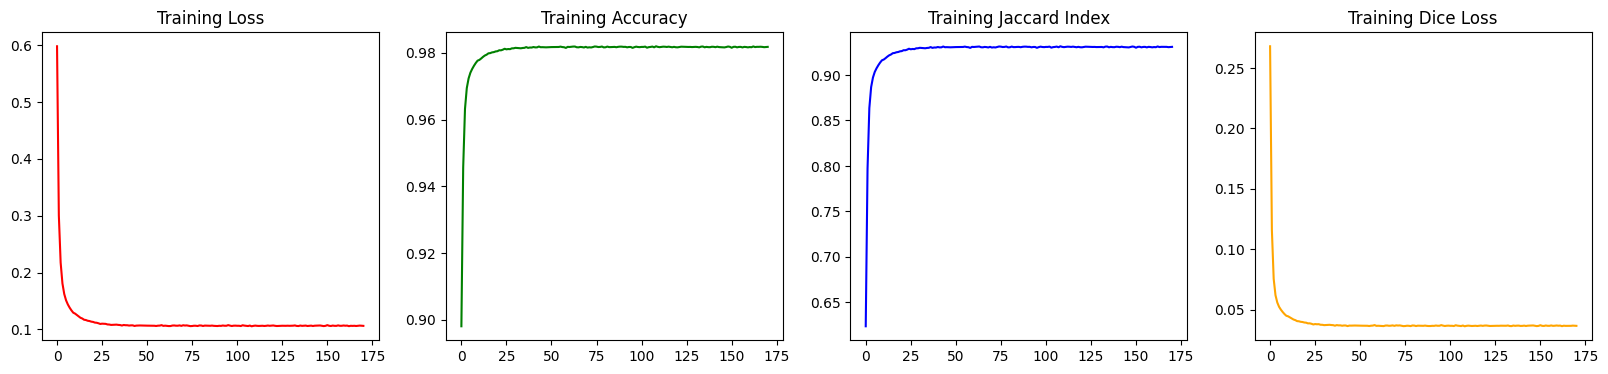

In [36]:
#plot train loss and train accuracy-
fig,ax = plt.subplots(1,4, figsize=(20,4))
ax[0].plot(train_loss, color="red")
ax[0].set_title("Training Loss")
ax[1].plot(train_acc, color="green")
ax[1].set_title("Training Accuracy")
ax[2].plot(train_jacc, color="blue")
ax[2].set_title("Training Jaccard Index")
ax[3].plot(train_dice, color = "orange")
ax[3].set_title("Training Dice Loss")
plt.show()


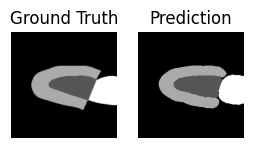

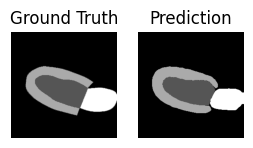

Testing Time: 0.004830467700958252 | Testing Loss: 0.0961366817355156 | Testing Accuracy: 0.9845190048217773 | Testing Jaccard: 0.9409419298171997 | Testing Dice: 0.03106367588043213


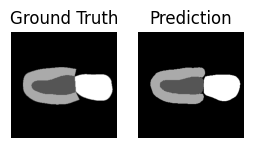

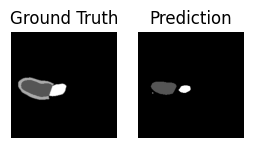

Testing Time: 0.0029591957728068033 | Testing Loss: 0.08844228088855743 | Testing Accuracy: 0.9848756790161133 | Testing Jaccard: 0.9421560764312744 | Testing Dice: 0.030448555946350098


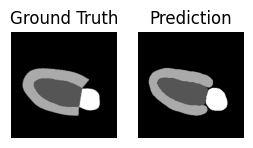

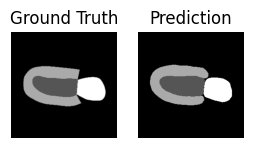

Testing Time: 0.002940241495768229 | Testing Loss: 0.08489789068698883 | Testing Accuracy: 0.9863061904907227 | Testing Jaccard: 0.9476138353347778 | Testing Dice: 0.0274813175201416


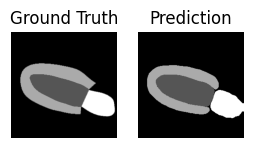

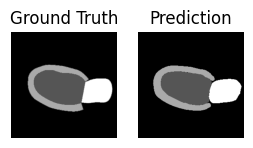

Testing Time: 0.0028150399525960286 | Testing Loss: 0.10316253453493118 | Testing Accuracy: 0.9832334518432617 | Testing Jaccard: 0.9358630180358887 | Testing Dice: 0.0336989164352417


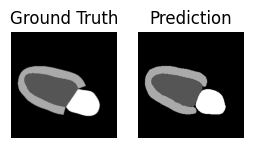

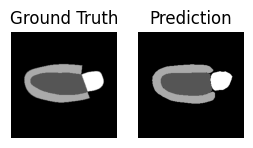

Testing Time: 0.002844734986623128 | Testing Loss: 0.09230383485555649 | Testing Accuracy: 0.9851474761962891 | Testing Jaccard: 0.9432592988014221 | Testing Dice: 0.029814720153808594


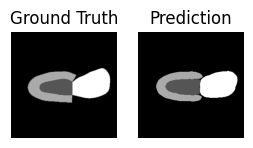

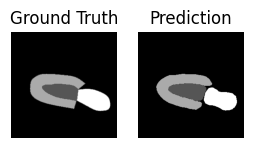

Testing Time: 0.004363747437795004 | Testing Loss: 0.09294363856315613 | Testing Accuracy: 0.9853010177612305 | Testing Jaccard: 0.9436778426170349 | Testing Dice: 0.02953314781188965


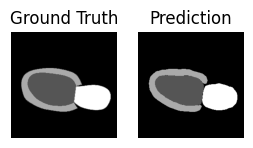

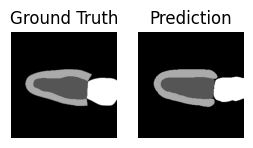

Testing Time: 0.002789592742919922 | Testing Loss: 0.09674789756536484 | Testing Accuracy: 0.9838657379150391 | Testing Jaccard: 0.9382638931274414 | Testing Dice: 0.032389163970947266


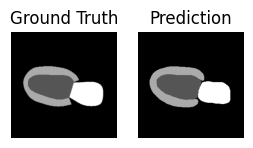

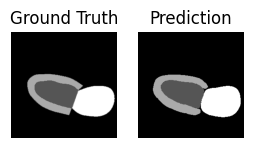

Testing Time: 0.002776793638865153 | Testing Loss: 0.09501399099826813 | Testing Accuracy: 0.9851408004760742 | Testing Jaccard: 0.9431841373443604 | Testing Dice: 0.02984696626663208


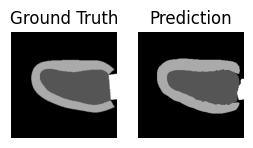

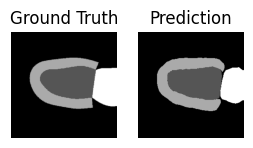

Testing Time: 0.0028385241826375325 | Testing Loss: 0.11153432726860046 | Testing Accuracy: 0.9814462661743164 | Testing Jaccard: 0.9296436309814453 | Testing Dice: 0.03727412223815918


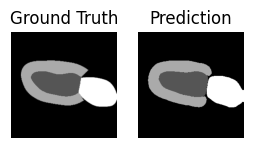

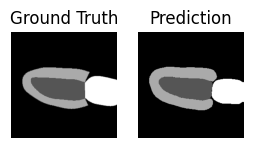

Testing Time: 0.0028650561968485513 | Testing Loss: 0.10106004774570465 | Testing Accuracy: 0.9830894470214844 | Testing Jaccard: 0.935164749622345 | Testing Dice: 0.033960580825805664


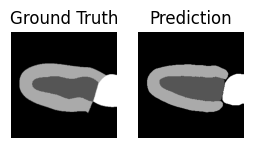

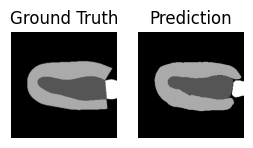

Testing Time: 0.0028316458066304524 | Testing Loss: 0.10328911989927292 | Testing Accuracy: 0.9818973541259766 | Testing Jaccard: 0.9309648275375366 | Testing Dice: 0.03633773326873779


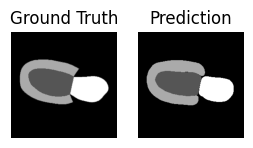

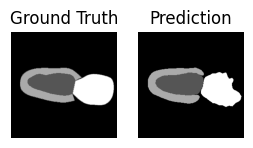

Testing Time: 0.002797071139017741 | Testing Loss: 0.10379557311534882 | Testing Accuracy: 0.9825000762939453 | Testing Jaccard: 0.9336773157119751 | Testing Dice: 0.03513449430465698


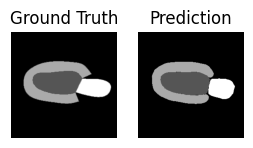

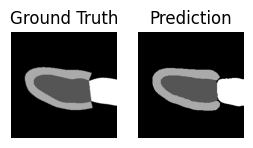

Testing Time: 0.0027828534444173177 | Testing Loss: 0.09262144565582275 | Testing Accuracy: 0.9848871231079102 | Testing Jaccard: 0.9424951672554016 | Testing Dice: 0.030346930027008057


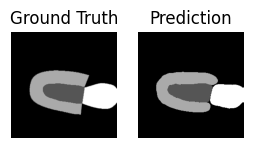

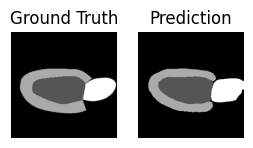

Testing Time: 0.0027854879697163898 | Testing Loss: 0.10198225826025009 | Testing Accuracy: 0.9834880828857422 | Testing Jaccard: 0.9369539618492126 | Testing Dice: 0.03314310312271118


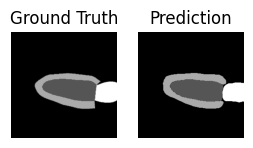

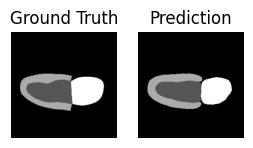

Testing Time: 0.003962651888529459 | Testing Loss: 0.08785378932952881 | Testing Accuracy: 0.985814094543457 | Testing Jaccard: 0.9459182024002075 | Testing Dice: 0.028463900089263916


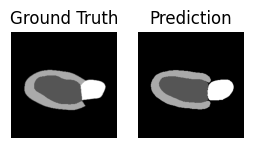

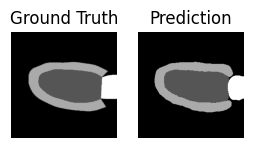

Testing Time: 0.002771917978922526 | Testing Loss: 0.09061992913484573 | Testing Accuracy: 0.9851198196411133 | Testing Jaccard: 0.9429959058761597 | Testing Dice: 0.02986598014831543


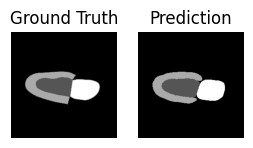

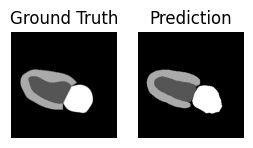

Testing Time: 0.002831061681111654 | Testing Loss: 0.08840953558683395 | Testing Accuracy: 0.985264778137207 | Testing Jaccard: 0.943664014339447 | Testing Dice: 0.029573440551757812


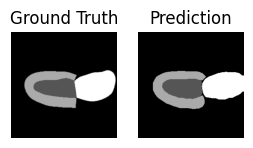

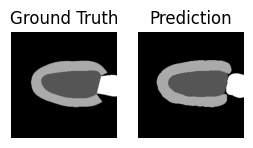

Testing Time: 0.0028148889541625977 | Testing Loss: 0.09240400791168213 | Testing Accuracy: 0.9847402572631836 | Testing Jaccard: 0.9419029951095581 | Testing Dice: 0.030633211135864258


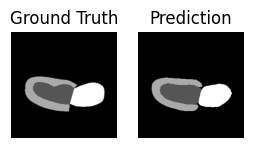

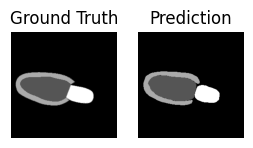

Testing Time: 0.002861940860748291 | Testing Loss: 0.09131354838609695 | Testing Accuracy: 0.9845237731933594 | Testing Jaccard: 0.94113689661026 | Testing Dice: 0.031071186065673828


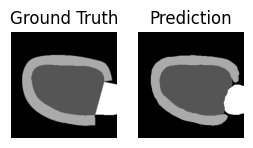

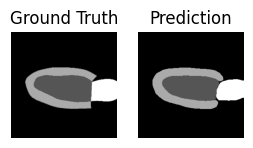

Testing Time: 0.0027915239334106445 | Testing Loss: 0.10879223793745041 | Testing Accuracy: 0.9826011657714844 | Testing Jaccard: 0.9337921142578125 | Testing Dice: 0.03496366739273071


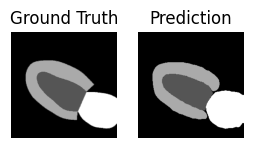

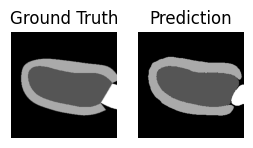

Testing Time: 0.002817090352376302 | Testing Loss: 0.10935099422931671 | Testing Accuracy: 0.9820642471313477 | Testing Jaccard: 0.9315875768661499 | Testing Dice: 0.03604322671890259


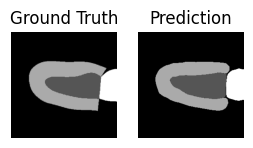

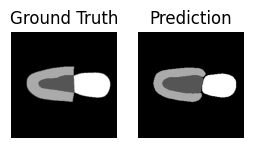

Testing Time: 0.002780803044637044 | Testing Loss: 0.10128764808177948 | Testing Accuracy: 0.9828586578369141 | Testing Jaccard: 0.9347883462905884 | Testing Dice: 0.034408390522003174


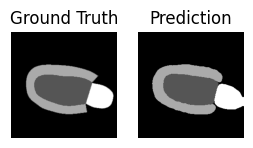

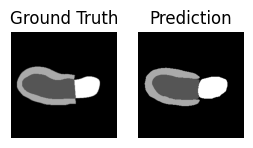

Testing Time: 0.0027843316396077475 | Testing Loss: 0.09390360116958618 | Testing Accuracy: 0.9847993850708008 | Testing Jaccard: 0.9423732757568359 | Testing Dice: 0.030519723892211914


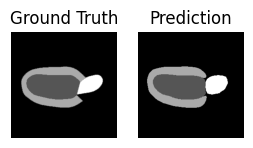

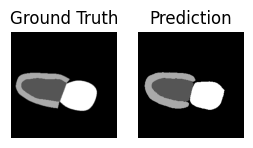

Testing Time: 0.0027730623881022137 | Testing Loss: 0.08917839080095291 | Testing Accuracy: 0.9856081008911133 | Testing Jaccard: 0.9450359344482422 | Testing Dice: 0.028883278369903564


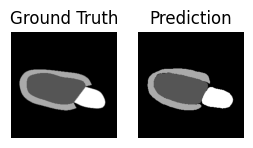

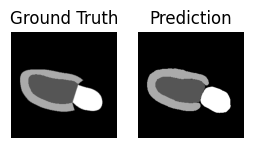

Testing Time: 0.0040498773256937666 | Testing Loss: 0.10423937439918518 | Testing Accuracy: 0.9826545715332031 | Testing Jaccard: 0.9339426755905151 | Testing Dice: 0.034856319427490234


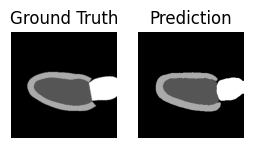

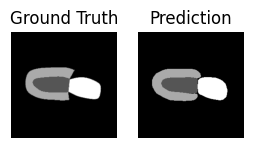

Testing Time: 0.002796014149983724 | Testing Loss: 0.1004791408777237 | Testing Accuracy: 0.9825983047485352 | Testing Jaccard: 0.9340385794639587 | Testing Dice: 0.03492981195449829


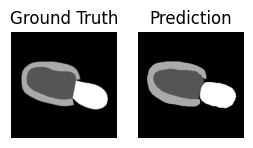

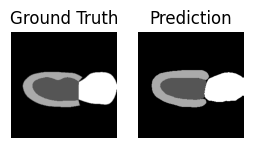

Testing Time: 0.002787915865580241 | Testing Loss: 0.09969450533390045 | Testing Accuracy: 0.9835758209228516 | Testing Jaccard: 0.937194287776947 | Testing Dice: 0.03297746181488037


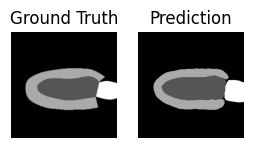

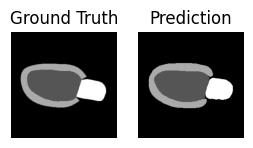

Testing Time: 0.0027739286422729494 | Testing Loss: 0.108571358025074 | Testing Accuracy: 0.9809999465942383 | Testing Jaccard: 0.9280911684036255 | Testing Dice: 0.03816258907318115


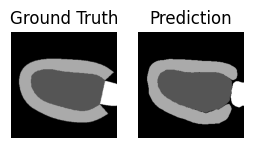

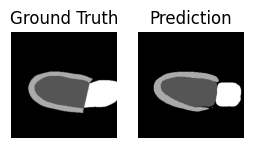

Testing Time: 0.0028121034304300946 | Testing Loss: 0.12463638931512833 | Testing Accuracy: 0.9805192947387695 | Testing Jaccard: 0.9263770580291748 | Testing Dice: 0.03920036554336548


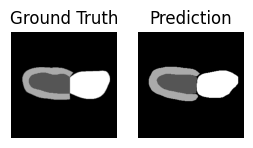

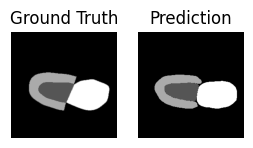

Testing Time: 0.0027777632077534992 | Testing Loss: 0.09745845943689346 | Testing Accuracy: 0.9840459823608398 | Testing Jaccard: 0.9388251900672913 | Testing Dice: 0.032033562660217285


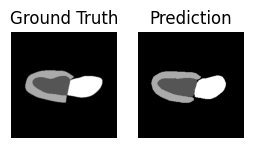

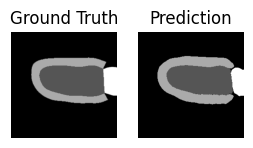

Testing Time: 0.002751501401265462 | Testing Loss: 0.09757715463638306 | Testing Accuracy: 0.9833946228027344 | Testing Jaccard: 0.93668532371521 | Testing Dice: 0.03332167863845825


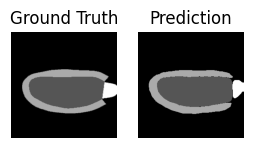

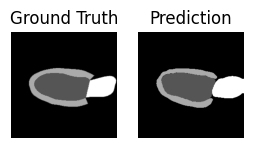

Testing Time: 0.002783819039662679 | Testing Loss: 0.09415222704410553 | Testing Accuracy: 0.9849691390991211 | Testing Jaccard: 0.9426782131195068 | Testing Dice: 0.030184447765350342


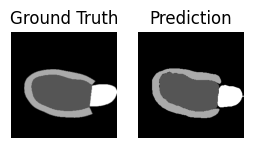

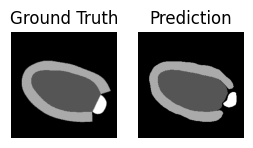

Testing Time: 0.0028313557306925458 | Testing Loss: 0.1107167974114418 | Testing Accuracy: 0.9809608459472656 | Testing Jaccard: 0.9279199838638306 | Testing Dice: 0.038271963596343994


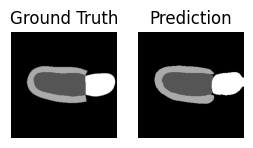

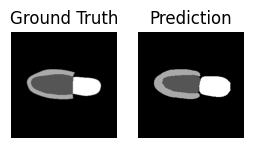

Testing Time: 0.0027801235516866046 | Testing Loss: 0.10480852425098419 | Testing Accuracy: 0.9821481704711914 | Testing Jaccard: 0.9319665431976318 | Testing Dice: 0.03587651252746582


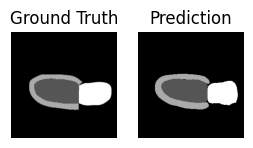

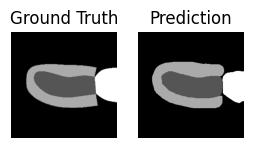

Testing Time: 0.003946173191070557 | Testing Loss: 0.0889388918876648 | Testing Accuracy: 0.9860906600952148 | Testing Jaccard: 0.9467537999153137 | Testing Dice: 0.02792191505432129


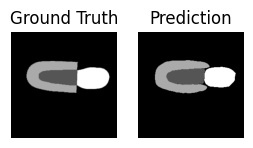

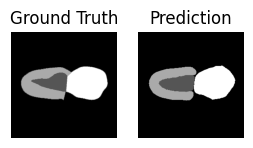

Testing Time: 0.0028161048889160157 | Testing Loss: 0.09464079886674881 | Testing Accuracy: 0.9842166900634766 | Testing Jaccard: 0.9397225975990295 | Testing Dice: 0.03168672323226929


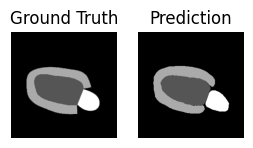

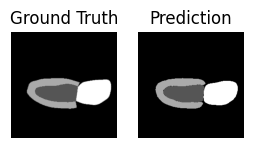

Testing Time: 0.0028623660405476888 | Testing Loss: 0.09531370550394058 | Testing Accuracy: 0.9852981567382812 | Testing Jaccard: 0.9442090392112732 | Testing Dice: 0.029515862464904785


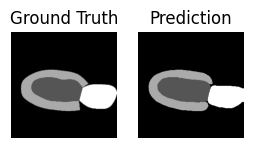

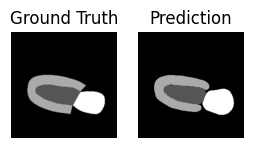

Testing Time: 0.002787629763285319 | Testing Loss: 0.09052541851997375 | Testing Accuracy: 0.9864273071289062 | Testing Jaccard: 0.9477697014808655 | Testing Dice: 0.02724742889404297


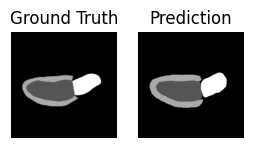

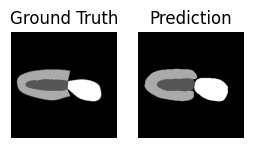

Testing Time: 0.00278775691986084 | Testing Loss: 0.08873635530471802 | Testing Accuracy: 0.9854650497436523 | Testing Jaccard: 0.9443666338920593 | Testing Dice: 0.029176294803619385


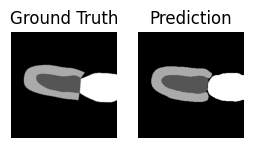

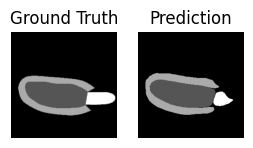

Testing Time: 0.0028221567471822103 | Testing Loss: 0.11659061908721924 | Testing Accuracy: 0.97918701171875 | Testing Jaccard: 0.9207611680030823 | Testing Dice: 0.04187124967575073


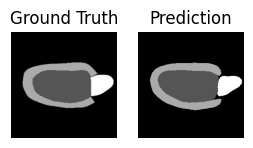

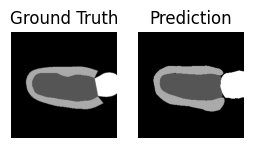

Testing Time: 0.0028223832448323566 | Testing Loss: 0.09803345799446106 | Testing Accuracy: 0.9834003448486328 | Testing Jaccard: 0.9365696310997009 | Testing Dice: 0.03333556652069092


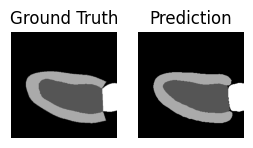

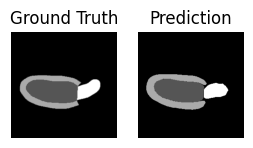

Testing Time: 0.0028669277826944986 | Testing Loss: 0.09100262075662613 | Testing Accuracy: 0.9850502014160156 | Testing Jaccard: 0.9429547786712646 | Testing Dice: 0.030000150203704834


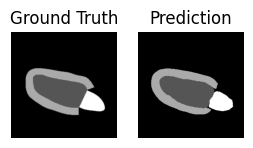

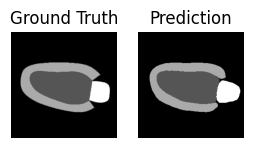

Testing Time: 0.00281987984975179 | Testing Loss: 0.09622584283351898 | Testing Accuracy: 0.9849557876586914 | Testing Jaccard: 0.942644476890564 | Testing Dice: 0.03020387887954712


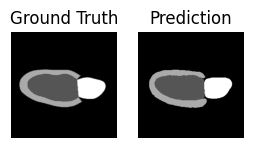

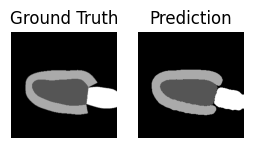

Testing Time: 0.0040159503618876135 | Testing Loss: 0.09393906593322754 | Testing Accuracy: 0.9845399856567383 | Testing Jaccard: 0.9407923817634583 | Testing Dice: 0.031041860580444336


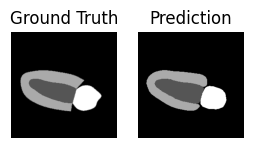

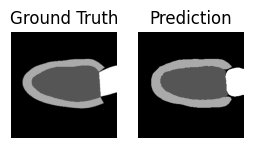

Testing Time: 0.0027764002482096356 | Testing Loss: 0.092336006462574 | Testing Accuracy: 0.9851360321044922 | Testing Jaccard: 0.9434068202972412 | Testing Dice: 0.0298578143119812


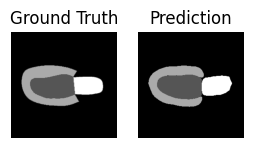

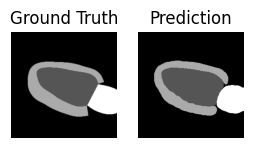

Testing Time: 0.0028670589129130048 | Testing Loss: 0.10885420441627502 | Testing Accuracy: 0.9814615249633789 | Testing Jaccard: 0.9297653436660767 | Testing Dice: 0.037229061126708984


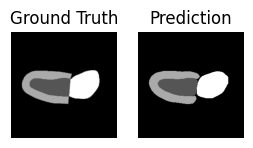

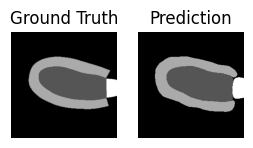

Testing Time: 0.0027747114499409994 | Testing Loss: 0.09411691874265671 | Testing Accuracy: 0.9838361740112305 | Testing Jaccard: 0.9383904933929443 | Testing Dice: 0.03244298696517944


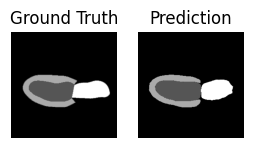

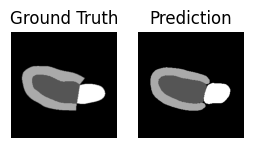

Testing Time: 0.0028057098388671875 | Testing Loss: 0.08491888642311096 | Testing Accuracy: 0.986109733581543 | Testing Jaccard: 0.9466356635093689 | Testing Dice: 0.027870476245880127


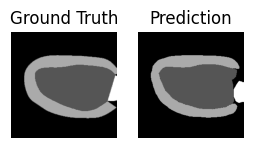

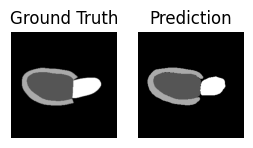

Testing Time: 0.002935500939687093 | Testing Loss: 0.10720951855182648 | Testing Accuracy: 0.9818716049194336 | Testing Jaccard: 0.930881917476654 | Testing Dice: 0.036601364612579346


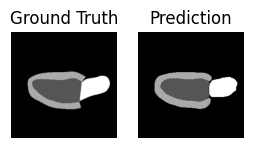

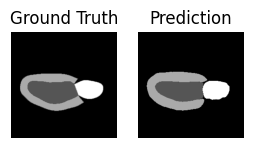

Testing Time: 0.0027784546216328937 | Testing Loss: 0.09070740640163422 | Testing Accuracy: 0.9841709136962891 | Testing Jaccard: 0.939752459526062 | Testing Dice: 0.031796276569366455


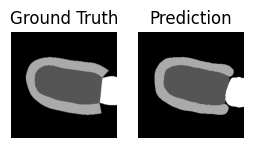

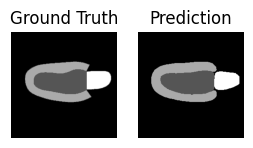

Testing Time: 0.0028482556343078615 | Testing Loss: 0.09539712965488434 | Testing Accuracy: 0.9843435287475586 | Testing Jaccard: 0.9403589963912964 | Testing Dice: 0.03143346309661865


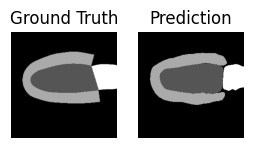

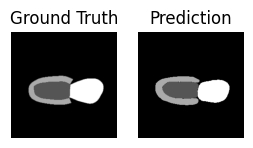

Testing Time: 0.002816657225290934 | Testing Loss: 0.10053922235965729 | Testing Accuracy: 0.9834613800048828 | Testing Jaccard: 0.9375512599945068 | Testing Dice: 0.033220648765563965


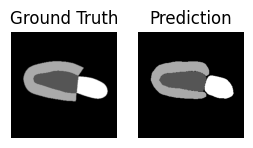

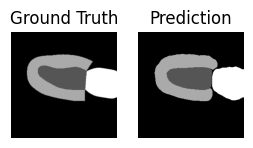

Testing Time: 0.002793904145558675 | Testing Loss: 0.09651808440685272 | Testing Accuracy: 0.9851131439208984 | Testing Jaccard: 0.9429891109466553 | Testing Dice: 0.029886305332183838


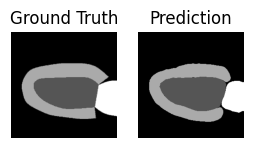

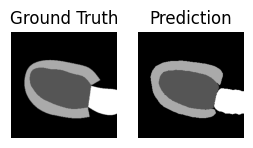

Testing Time: 0.00397802988688151 | Testing Loss: 0.10935769975185394 | Testing Accuracy: 0.9822177886962891 | Testing Jaccard: 0.932350218296051 | Testing Dice: 0.03572678565979004


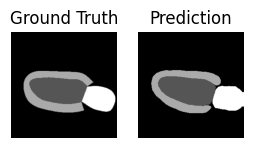

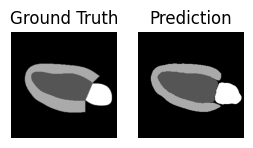

Testing Time: 0.002829289436340332 | Testing Loss: 0.1150529533624649 | Testing Accuracy: 0.9809112548828125 | Testing Jaccard: 0.9277962446212769 | Testing Dice: 0.038374900817871094


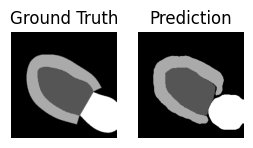

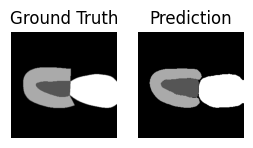

Testing Time: 0.0028220375378926596 | Testing Loss: 0.11505627632141113 | Testing Accuracy: 0.9818668365478516 | Testing Jaccard: 0.9309573769569397 | Testing Dice: 0.03649836778640747


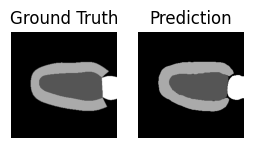

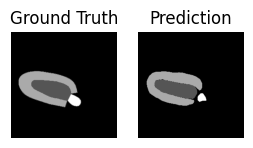

Testing Time: 0.002811582883199056 | Testing Loss: 0.0910084992647171 | Testing Accuracy: 0.9851970672607422 | Testing Jaccard: 0.943585216999054 | Testing Dice: 0.029729902744293213


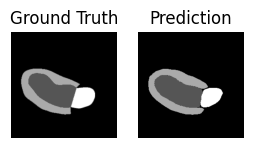

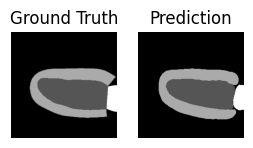

Testing Time: 0.002851978937784831 | Testing Loss: 0.10222010314464569 | Testing Accuracy: 0.9825649261474609 | Testing Jaccard: 0.9337650537490845 | Testing Dice: 0.03502011299133301


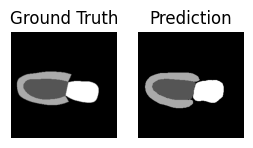

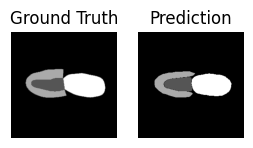

Testing Time: 0.0028647343317667645 | Testing Loss: 0.09387286752462387 | Testing Accuracy: 0.9843473434448242 | Testing Jaccard: 0.9400631189346313 | Testing Dice: 0.03147411346435547


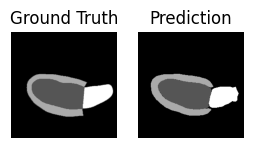

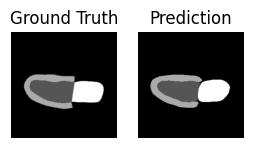

Testing Time: 0.0028248111406962077 | Testing Loss: 0.09546393156051636 | Testing Accuracy: 0.9844484329223633 | Testing Jaccard: 0.9404019117355347 | Testing Dice: 0.031244874000549316


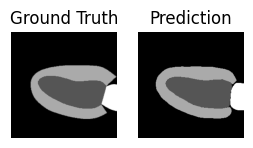

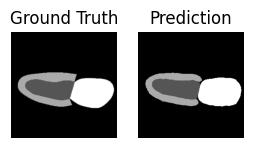

Testing Time: 0.0027707854906717936 | Testing Loss: 0.10643032193183899 | Testing Accuracy: 0.9819316864013672 | Testing Jaccard: 0.9313773512840271 | Testing Dice: 0.03627532720565796


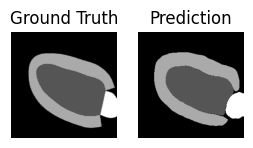

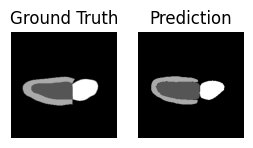

Testing Time: 0.0027904868125915526 | Testing Loss: 0.11230491101741791 | Testing Accuracy: 0.9805793762207031 | Testing Jaccard: 0.9265433549880981 | Testing Dice: 0.039047300815582275


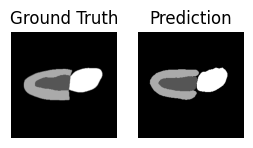

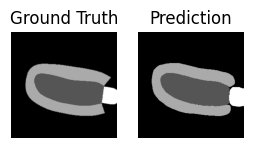

Testing Time: 0.002889243761698405 | Testing Loss: 0.0880671814084053 | Testing Accuracy: 0.9861545562744141 | Testing Jaccard: 0.9468159079551697 | Testing Dice: 0.027802646160125732


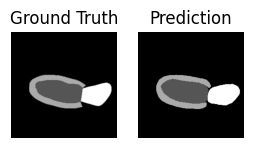

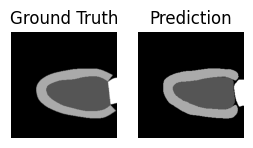

Testing Time: 0.003620179494222005 | Testing Loss: 0.09022756665945053 | Testing Accuracy: 0.9850625991821289 | Testing Jaccard: 0.9427820444107056 | Testing Dice: 0.029995739459991455


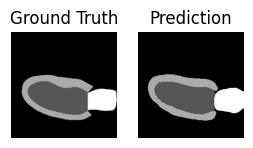

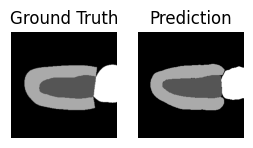

Testing Time: 0.002793872356414795 | Testing Loss: 0.09908799827098846 | Testing Accuracy: 0.9833545684814453 | Testing Jaccard: 0.9369440674781799 | Testing Dice: 0.03342723846435547


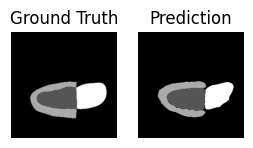

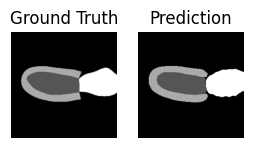

Testing Time: 0.002826948960622152 | Testing Loss: 0.09379098564386368 | Testing Accuracy: 0.9842138290405273 | Testing Jaccard: 0.9403411149978638 | Testing Dice: 0.03170430660247803


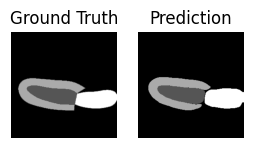

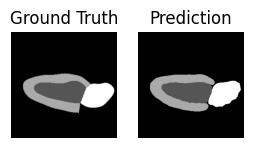

Testing Time: 0.002829873561859131 | Testing Loss: 0.0965004488825798 | Testing Accuracy: 0.9841289520263672 | Testing Jaccard: 0.9391964077949524 | Testing Dice: 0.03186845779418945


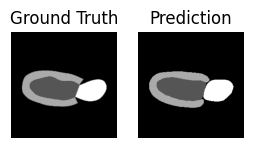

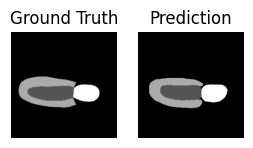

Testing Time: 0.0028061230977376303 | Testing Loss: 0.08893293142318726 | Testing Accuracy: 0.9855422973632812 | Testing Jaccard: 0.944593608379364 | Testing Dice: 0.029018282890319824


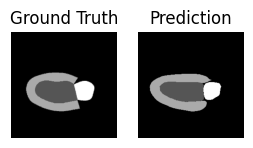

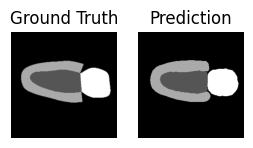

Testing Time: 0.0028728961944580076 | Testing Loss: 0.09674553573131561 | Testing Accuracy: 0.983424186706543 | Testing Jaccard: 0.9371361136436462 | Testing Dice: 0.03327757120132446


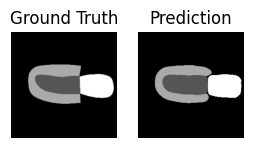

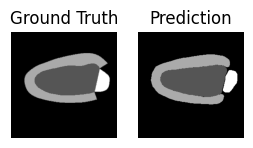

Testing Time: 0.002809806664784749 | Testing Loss: 0.1032145693898201 | Testing Accuracy: 0.9828901290893555 | Testing Jaccard: 0.9349786639213562 | Testing Dice: 0.034367501735687256


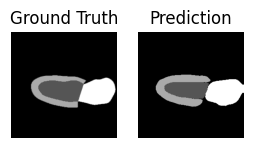

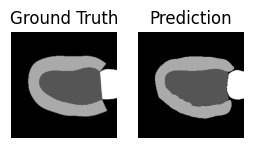

Testing Time: 0.0028407772382100425 | Testing Loss: 0.10614796727895737 | Testing Accuracy: 0.9822988510131836 | Testing Jaccard: 0.9327161312103271 | Testing Dice: 0.035567283630371094


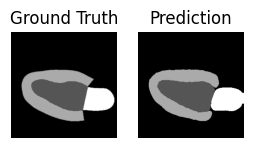

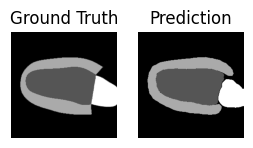

Testing Time: 0.0028383811314900715 | Testing Loss: 0.10596898198127747 | Testing Accuracy: 0.9824619293212891 | Testing Jaccard: 0.9332112073898315 | Testing Dice: 0.03523576259613037


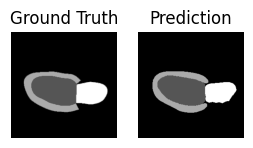

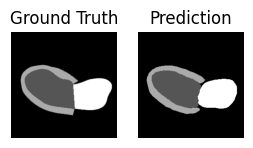

Testing Time: 0.00409310261408488 | Testing Loss: 0.0980672687292099 | Testing Accuracy: 0.9837150573730469 | Testing Jaccard: 0.9380015134811401 | Testing Dice: 0.0327150821685791


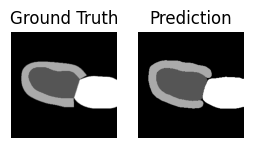

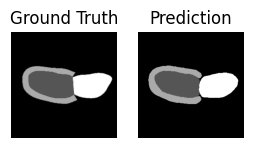

Testing Time: 0.0028061509132385255 | Testing Loss: 0.10338572412729263 | Testing Accuracy: 0.9825801849365234 | Testing Jaccard: 0.933673083782196 | Testing Dice: 0.034980595111846924


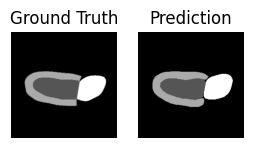

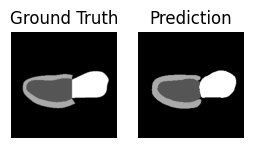

Testing Time: 0.002818731466929118 | Testing Loss: 0.08173318207263947 | Testing Accuracy: 0.9874773025512695 | Testing Jaccard: 0.9518524408340454 | Testing Dice: 0.025124192237854004


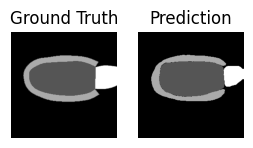

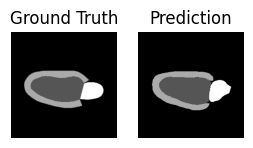

Testing Time: 0.0027647495269775392 | Testing Loss: 0.10086663067340851 | Testing Accuracy: 0.9827909469604492 | Testing Jaccard: 0.9348520040512085 | Testing Dice: 0.0345727801322937


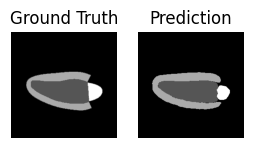

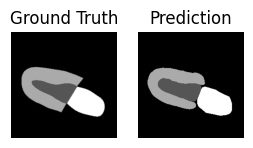

Testing Time: 0.00287321408589681 | Testing Loss: 0.09850599616765976 | Testing Accuracy: 0.9832916259765625 | Testing Jaccard: 0.9366125464439392 | Testing Dice: 0.03355121612548828


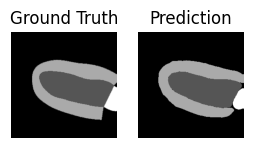

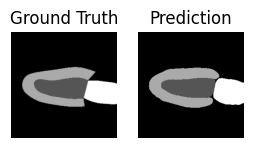

Testing Time: 0.002854947249094645 | Testing Loss: 0.09968505799770355 | Testing Accuracy: 0.9842214584350586 | Testing Jaccard: 0.9394352436065674 | Testing Dice: 0.03167694807052612


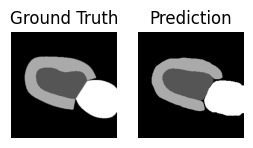

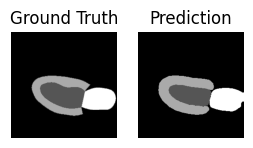

Testing Time: 0.002817217508951823 | Testing Loss: 0.10082170367240906 | Testing Accuracy: 0.9831380844116211 | Testing Jaccard: 0.9354308247566223 | Testing Dice: 0.0338670015335083


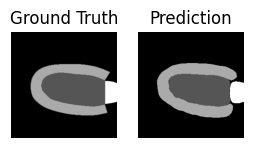

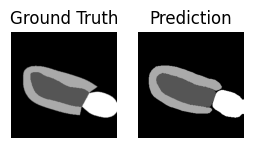

Testing Time: 0.002861932913462321 | Testing Loss: 0.10121427476406097 | Testing Accuracy: 0.9835586547851562 | Testing Jaccard: 0.9371588826179504 | Testing Dice: 0.033013999462127686


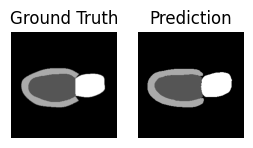

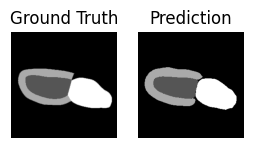

Testing Time: 0.0028108517328898114 | Testing Loss: 0.0901225283741951 | Testing Accuracy: 0.9857769012451172 | Testing Jaccard: 0.9454531669616699 | Testing Dice: 0.028550922870635986


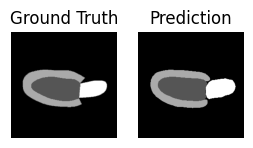

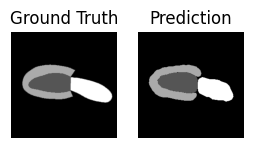

Testing Time: 0.0028827428817749024 | Testing Loss: 0.09441834688186646 | Testing Accuracy: 0.9842195510864258 | Testing Jaccard: 0.9395936727523804 | Testing Dice: 0.031674087047576904


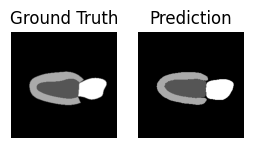

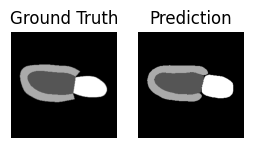

Testing Time: 0.003974882761637369 | Testing Loss: 0.09110663831233978 | Testing Accuracy: 0.984827995300293 | Testing Jaccard: 0.9417344331741333 | Testing Dice: 0.030458688735961914


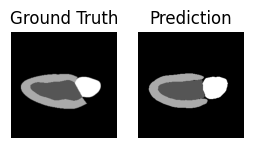

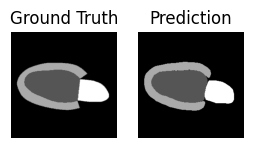

Testing Time: 0.002800468603769938 | Testing Loss: 0.0958295539021492 | Testing Accuracy: 0.9844474792480469 | Testing Jaccard: 0.9404217600822449 | Testing Dice: 0.03122323751449585


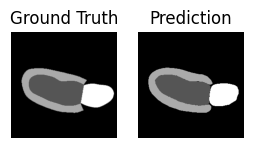

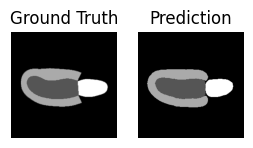

Testing Time: 0.0028424898783365885 | Testing Loss: 0.10138078033924103 | Testing Accuracy: 0.9828119277954102 | Testing Jaccard: 0.9347286820411682 | Testing Dice: 0.034503042697906494


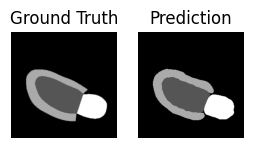

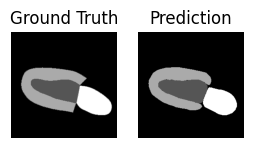

Testing Time: 0.0028110384941101075 | Testing Loss: 0.08937758207321167 | Testing Accuracy: 0.985661506652832 | Testing Jaccard: 0.9448503851890564 | Testing Dice: 0.02878284454345703


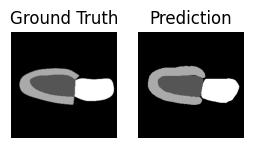

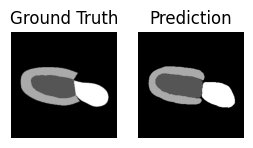

Testing Time: 0.0027761499087015787 | Testing Loss: 0.08996187150478363 | Testing Accuracy: 0.9848976135253906 | Testing Jaccard: 0.942170262336731 | Testing Dice: 0.030330002307891846


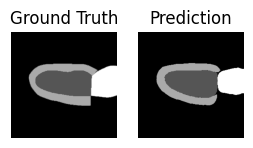

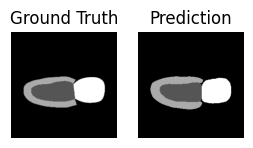

Testing Time: 0.0028104225794474283 | Testing Loss: 0.09852517396211624 | Testing Accuracy: 0.9835147857666016 | Testing Jaccard: 0.9375447630882263 | Testing Dice: 0.03309661149978638


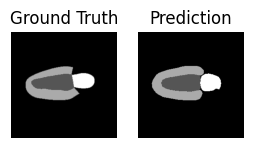

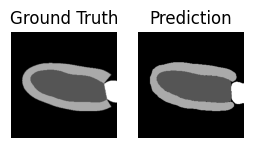

Testing Time: 0.002801048755645752 | Testing Loss: 0.09091346710920334 | Testing Accuracy: 0.9851264953613281 | Testing Jaccard: 0.9432264566421509 | Testing Dice: 0.02985060214996338


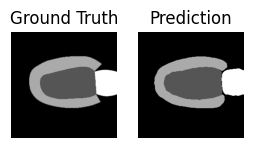

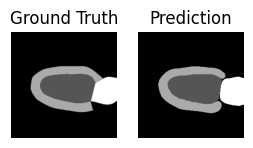

Testing Time: 0.002822697162628174 | Testing Loss: 0.09245435893535614 | Testing Accuracy: 0.9851818084716797 | Testing Jaccard: 0.9432621002197266 | Testing Dice: 0.02974182367324829


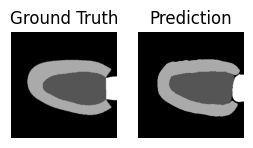

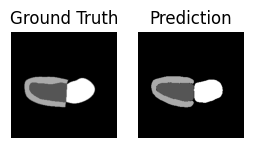

Testing Time: 0.002776058514912923 | Testing Loss: 0.09765615314245224 | Testing Accuracy: 0.9830694198608398 | Testing Jaccard: 0.9355619549751282 | Testing Dice: 0.03399658203125


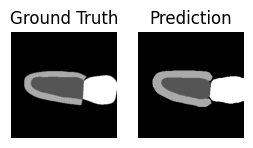

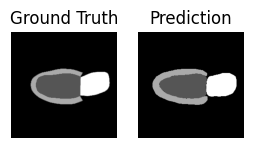

Testing Time: 0.004124919573465983 | Testing Loss: 0.10340611636638641 | Testing Accuracy: 0.9824237823486328 | Testing Jaccard: 0.9334226846694946 | Testing Dice: 0.035270631313323975


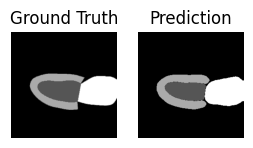

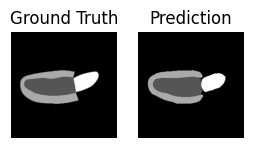

Testing Time: 0.0028233766555786134 | Testing Loss: 0.0942268818616867 | Testing Accuracy: 0.9851856231689453 | Testing Jaccard: 0.9431194067001343 | Testing Dice: 0.02974843978881836


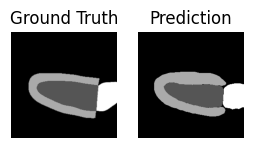

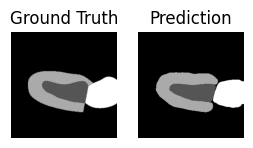

Testing Time: 0.0028127511342366535 | Testing Loss: 0.10088394582271576 | Testing Accuracy: 0.9825115203857422 | Testing Jaccard: 0.933594822883606 | Testing Dice: 0.035114169120788574


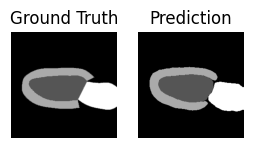

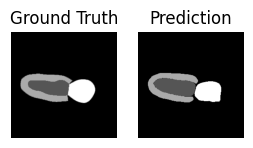

Testing Time: 0.002824278672536214 | Testing Loss: 0.09473882615566254 | Testing Accuracy: 0.9840145111083984 | Testing Jaccard: 0.9385874271392822 | Testing Dice: 0.032104671001434326


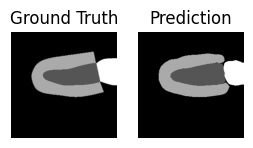

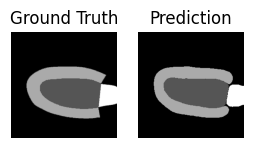

Testing Time: 0.0029210329055786135 | Testing Loss: 0.09578593075275421 | Testing Accuracy: 0.9842796325683594 | Testing Jaccard: 0.9402391910552979 | Testing Dice: 0.03154730796813965


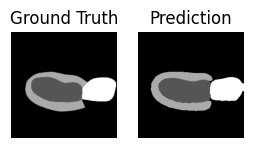

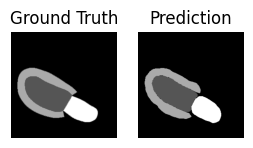

Testing Time: 0.0027904828389485677 | Testing Loss: 0.10519842058420181 | Testing Accuracy: 0.9826078414916992 | Testing Jaccard: 0.9338393211364746 | Testing Dice: 0.034950196743011475


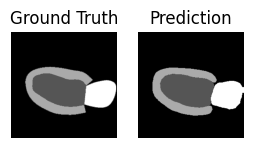

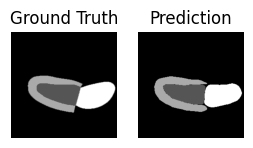

Testing Time: 0.002841981252034505 | Testing Loss: 0.09437039494514465 | Testing Accuracy: 0.9843254089355469 | Testing Jaccard: 0.939907968044281 | Testing Dice: 0.031471848487854004


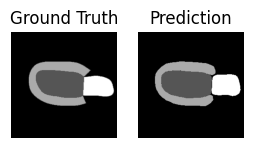

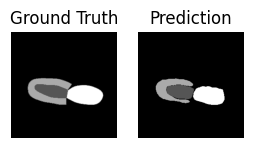

Testing Time: 0.0028407971064249673 | Testing Loss: 0.10142337530851364 | Testing Accuracy: 0.9826869964599609 | Testing Jaccard: 0.9340711236000061 | Testing Dice: 0.03478878736495972


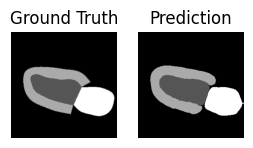

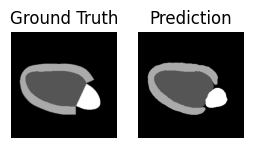

Testing Time: 0.002840737501780192 | Testing Loss: 0.09974014014005661 | Testing Accuracy: 0.9838294982910156 | Testing Jaccard: 0.9382461905479431 | Testing Dice: 0.03248155117034912


In [37]:
#Evaluate the model on test data-
model.eval()
test_loss = []
test_acc = []
test_jacc = []
test_dice = []

for batch in test_dl:
    start = time.time()
    img, label = batch
    img = img.to(device).float()
    pred = model(img)['out']
    label = label.float()
    #keep pred in cpu to calculate loss
    pred = pred.cpu()
    loss = criteria(pred, label)
    pred = F.softmax(pred, dim=1)
    #put 1 if elements of pred is greater than 0.5 else 0
    pred = torch.where(pred>=0.5, torch.tensor(1), torch.tensor(0))
    test_loss.append(loss.item())
    test_acc.append(cal_accuracy(pred, label))
    test_jacc.append(cal_iou(pred, label))
    test_dice.append(calculate_dice(pred, label))
    
    for i in range(len(batch)):
        new_lable = torch.zeros((256, 256))
        new_lable[:,:] = torch.where(label[i,0,:,:]==1, torch.tensor(0), torch.tensor(0)) + torch.where(label[i,1,:,:]==1, torch.tensor(1), torch.tensor(0)) + torch.where(label[i,2,:,:]==1, torch.tensor(2), torch.tensor(0)) + torch.where(label[i,3,:,:]==1, torch.tensor(3), torch.tensor(0))
        new_pred = torch.zeros((256, 256))
        new_pred = torch.where(pred[i,0,:,:]==1, torch.tensor(0), torch.tensor(0)) + torch.where(pred[i,1,:,:]==1, torch.tensor(1), torch.tensor(0)) + torch.where(pred[i,2,:,:]==1, torch.tensor(2), torch.tensor(0)) + torch.where(pred[i,3,:,:]==1, torch.tensor(3), torch.tensor(0))      
        fig, ax = plt.subplots(1,2, figsize=(3,3))
        ax[0].imshow(new_lable, cmap="gray")
        ax[0].set_title("Ground Truth")
        ax[1].imshow(new_pred.detach().numpy(), cmap="gray")
        ax[1].set_title("Prediction")
        [axi.set_axis_off() for axi in ax.ravel()]
        plt.show()
    
    end = time.time()
    testing_time = (end - start)/60
    print("Testing Time: {} | Testing Loss: {} | Testing Accuracy: {} | Testing Jaccard: {} | Testing Dice: {}".format(testing_time, loss.item(), cal_accuracy(pred, label), cal_iou(pred, label), calculate_dice(pred, label)))
